In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 22s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [12]:
shap_summary_df = pd.read_csv(basedir + 'shap_top_47.csv', index_col=[0]).sort_values(['shap_summary_mean'], ascending=False)
print(shap_summary_df.shape)
shap_summary_df.head()

(47, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,94.820716,89.995787,92.115376,95.384442,95.617199,93.586704
공시지가(만원),79.340233,76.859986,77.567496,77.289188,75.445312,77.300443
year_linear,64.413585,62.359725,64.603483,64.775827,64.484595,64.127443
건축년도,46.969523,47.437061,48.129198,47.850436,47.957250,47.668693
전용면적,40.870716,37.256955,40.681768,38.357426,40.770922,39.587557


In [13]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,94.820716,89.995787,92.115376,95.384442,95.617199,93.586704
공시지가(만원),79.340233,76.859986,77.567496,77.289188,75.445312,77.300443
year_linear,64.413585,62.359725,64.603483,64.775827,64.484595,64.127443
건축년도,46.969523,47.437061,48.129198,47.850436,47.957250,47.668693
전용면적,40.870716,37.256955,40.681768,38.357426,40.770922,39.587557
ynorm,31.142993,29.728605,31.683667,30.563589,30.367021,30.697175
xy,21.590209,20.801011,19.650856,21.500984,22.787364,21.266085
x_2nd,19.079826,18.730173,18.464523,18.489412,20.771321,19.107051
주건축물수,14.165298,12.910095,13.370128,13.578644,12.900315,13.384896
층mean,10.314252,12.640504,11.205216,9.527042,12.003689,11.138140


In [14]:
top_46_df = shap_summary_df.iloc[:46,:]
print(top_46_df.shape)

(46, 6)


In [15]:
top_46_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,94.820716,89.995787,92.115376,95.384442,95.617199,93.586704
공시지가(만원),79.340233,76.859986,77.567496,77.289188,75.445312,77.300443
year_linear,64.413585,62.359725,64.603483,64.775827,64.484595,64.127443
건축년도,46.969523,47.437061,48.129198,47.850436,47.957250,47.668693
전용면적,40.870716,37.256955,40.681768,38.357426,40.770922,39.587557


In [16]:
top_46_df.tail(20)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
지붕_평지붕_fraction,2.636330,2.410795,2.486092,2.641780,2.428103,2.520620
부속건축물면적,2.357003,2.646894,2.310353,2.591701,2.664509,2.514092
부속건축물수,2.648483,2.099067,1.683109,3.092558,2.974496,2.499543
지형높이,2.221429,2.608224,2.672804,2.520919,2.396278,2.483931
건물나이,2.408662,2.311280,2.348002,2.171733,2.337420,2.315419
옥외자주식대수,2.146135,2.198645,1.974064,2.178436,2.699646,2.239385
month_sin,2.262179,2.027792,2.327716,2.240439,2.149063,2.201438
층min,2.171203,2.147198,2.189815,2.337579,2.042310,2.177621
공원,2.350547,2.124849,1.843584,1.801535,2.285001,2.081103
(한강)폐기물매립시설_설치제한지역,2.023989,1.843362,1.986008,2.109209,1.847959,1.962105


In [17]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [18]:
training_data_df = training_data_df[top_46_df.index.tolist()+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 51)


,trade_type,공시지가(만원),year_linear,건축년도,전용면적,ynorm,xy,x_2nd,주건축물수,층mean,총건축면적,토지이동상황,xnorm,아파트지구,옥내자주식대수,호수대비연면적,호수대비부속건축물면적,층,총호수,호수대비주차수,y_2nd,용도지역명1,층norm,지구단위계획구역,가축사육제한구역,도로접면,지붕_평지붕_fraction,부속건축물면적,부속건축물수,지형높이,건물나이,옥외자주식대수,month_sin,층min,공원,(한강)폐기물매립시설_설치제한지역,지형형상,y_sin,y_cos,x_sin,x_cos,상대정화구역,정비구역,제3종일반주거지역,제1종지구단위계획구역,중점경관관리구역,금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,5579.095707,0,0.0,98.537963,0.0,2,54.0,0.0,4.094180e+07,0,0.222222,0,0,0,1.0,0.0,0.0,0,0,0.0,-0.866025,9.0,0,0,0,-0.920469,0.390815,-0.364267,0.931294,0,0,0,0,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
1,0,921.0,7.916667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,5579.095707,0,0.0,98.537963,0.0,2,54.0,0.0,4.094180e+07,0,0.222222,0,0,0,1.0,0.0,0.0,0,0,0.0,-0.500000,9.0,0,0,0,-0.920469,0.390815,-0.364267,0.931294,0,0,0,0,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
2,1,921.0,7.000000,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,5579.095707,0,0.0,98.537963,0.0,4,54.0,0.0,4.094180e+07,0,0.444444,0,0,0,1.0,0.0,0.0,0,0,0.0,0.000000,9.0,0,0,0,-0.920469,0.390815,-0.364267,0.931294,0,0,0,0,0,35000.0,450.160772,10.463103,6.109605,서울특별시 강남구 개포동 655-2
3,1,921.0,7.166667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,5579.095707,0,0.0,98.537963,0.0,9,54.0,0.0,4.094180e+07,0,1.000000,0,0,0,1.0,0.0,0.0,0,0,0.0,0.866025,9.0,0,0,0,-0.920469,0.390815,-0.364267,0.931294,0,0,0,0,0,32000.0,411.575563,10.373491,6.019993,서울특별시 강남구 개포동 655-2
4,1,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,5579.095707,0,0.0,98.537963,0.0,1,54.0,0.0,4.094180e+07,0,0.111111,0,0,0,1.0,0.0,0.0,0,0,0.0,-0.866025,9.0,0,0,0,-0.920469,0.390815,-0.364267,0.931294,0,0,0,0,0,37000.0,475.884244,10.518673,6.165175,서울특별시 강남구 개포동 655-2


# Training

In [19]:
from sklearn.model_selection import KFold, GroupKFold

In [20]:
import lightgbm as lgb

In [21]:
from sklearn.metrics import r2_score

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

17

In [24]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 46)
y dist plot


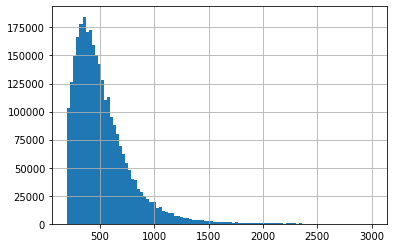

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5936
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 46
[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5819
[100]	valid_0's huber: 64.8771
[150]	valid_0's huber: 58.7202
[200]	valid_0's huber: 54.9568
[250]	valid_0's huber: 52.5571
[300]	valid_0's huber: 50.7847
[350]	valid_0's huber: 49.3413
[400]	valid_0's huber: 48.2228
[450]	valid_0's huber: 47.2793
[500]	valid_0's huber: 46.4464
[550]	valid_0's huber: 45.8441
[600]	valid_0's huber: 45.14
[650]	valid_0's huber: 44.623
[700]	valid_0's huber: 44.114
[750]	valid_0's huber: 43.6689
[800]	valid_0's huber: 43.2307
[850]	valid_0's huber: 42.8525
[90

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


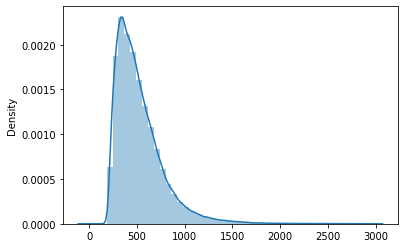

Fold 0 end
Fold 1 start
(2926581, 46)
y dist plot


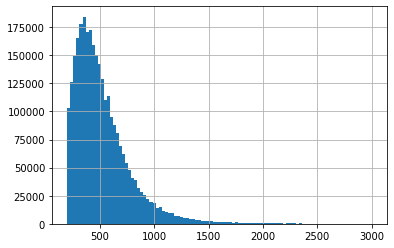

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.175621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5937
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 46


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6868
[100]	valid_0's huber: 64.9003
[150]	valid_0's huber: 58.6444
[200]	valid_0's huber: 54.9453
[250]	valid_0's huber: 52.3631
[300]	valid_0's huber: 50.5785
[350]	valid_0's huber: 49.1719
[400]	valid_0's huber: 48.0556
[450]	valid_0's huber: 47.0941
[500]	valid_0's huber: 46.2781
[550]	valid_0's huber: 45.5646
[600]	valid_0's huber: 44.9448
[650]	valid_0's huber: 44.3708
[700]	valid_0's huber: 43.8988
[750]	valid_0's huber: 43.4135
[800]	valid_0's huber: 43.014
[850]	valid_0's huber: 42.6909
[900]	valid_0's huber: 42.3518
[950]	valid_0's huber: 42.0199
[1000]	valid_0's huber: 41.7228
[1050]	valid_0's huber: 41.4234
[1100]	valid_0's huber: 41.1776
[1150]	valid_0's huber: 40.9239
[1200]	valid_0's huber: 40.7126
[1250]	valid_0's huber: 40.4923
[1300]	valid_0's huber: 40.2505
[1350]	valid_0's huber: 40.0349
[1400]	valid_0's huber: 39.8475
[1450]	v

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


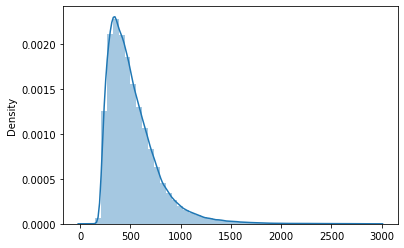

Fold 1 end
Fold 2 start
(2926581, 46)
y dist plot


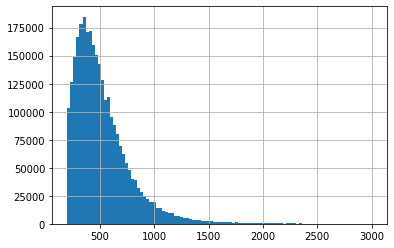

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5939
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 46


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.481
[100]	valid_0's huber: 64.6639
[150]	valid_0's huber: 58.4968
[200]	valid_0's huber: 54.8881
[250]	valid_0's huber: 52.4222
[300]	valid_0's huber: 50.626
[350]	valid_0's huber: 49.2729
[400]	valid_0's huber: 48.0647
[450]	valid_0's huber: 47.2533
[500]	valid_0's huber: 46.3855
[550]	valid_0's huber: 45.6722
[600]	valid_0's huber: 45.0208
[650]	valid_0's huber: 44.4256
[700]	valid_0's huber: 43.8799
[750]	valid_0's huber: 43.3985
[800]	valid_0's huber: 43.0597
[850]	valid_0's huber: 42.6145
[900]	valid_0's huber: 42.2411
[950]	valid_0's huber: 41.9293
[1000]	valid_0's huber: 41.6604
[1050]	valid_0's huber: 41.368
[1100]	valid_0's huber: 41.1159
[1150]	valid_0's huber: 40.8676
[1200]	valid_0's huber: 40.6131
[1250]	valid_0's huber: 40.406
[1300]	valid_0's huber: 40.1936
[1350]	valid_0's huber: 39.9803
[1400]	valid_0's huber: 39.8161
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


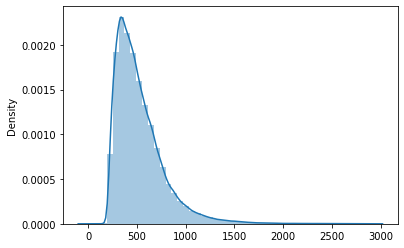

Fold 2 end
Fold 3 start
(2926581, 46)
y dist plot


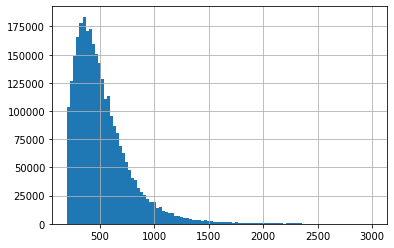

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.171681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5933
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 46


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5235
[100]	valid_0's huber: 64.7284
[150]	valid_0's huber: 58.7248
[200]	valid_0's huber: 55.0577
[250]	valid_0's huber: 52.6671
[300]	valid_0's huber: 50.9045
[350]	valid_0's huber: 49.4684
[400]	valid_0's huber: 48.2947
[450]	valid_0's huber: 47.5081
[500]	valid_0's huber: 46.6919
[550]	valid_0's huber: 46.057
[600]	valid_0's huber: 45.4988
[650]	valid_0's huber: 44.8287
[700]	valid_0's huber: 44.2129
[750]	valid_0's huber: 43.697
[800]	valid_0's huber: 43.2024
[850]	valid_0's huber: 42.7922
[900]	valid_0's huber: 42.4403
[950]	valid_0's huber: 42.1038
[1000]	valid_0's huber: 41.7678
[1050]	valid_0's huber: 41.4398
[1100]	valid_0's huber: 41.1578
[1150]	valid_0's huber: 40.886
[1200]	valid_0's huber: 40.6461
[1250]	valid_0's huber: 40.4161
[1300]	valid_0's huber: 40.1929
[1350]	valid_0's huber: 40.0043
[1400]	valid_0's huber: 39.7773
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


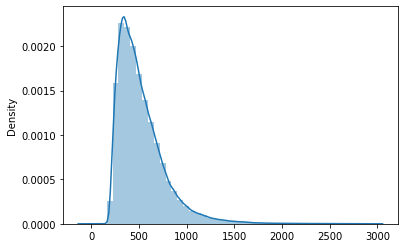

Fold 3 end
Fold 4 start
(2926581, 46)
y dist plot


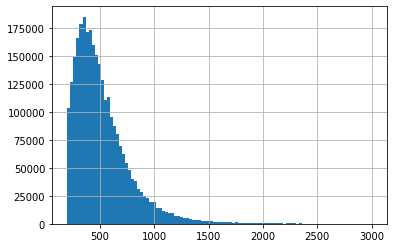

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5934
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 46


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4209
[100]	valid_0's huber: 64.789
[150]	valid_0's huber: 58.5971
[200]	valid_0's huber: 55.0564
[250]	valid_0's huber: 52.5892
[300]	valid_0's huber: 50.7124
[350]	valid_0's huber: 49.3883
[400]	valid_0's huber: 48.2415
[450]	valid_0's huber: 47.3246
[500]	valid_0's huber: 46.5297
[550]	valid_0's huber: 45.8615
[600]	valid_0's huber: 45.182
[650]	valid_0's huber: 44.5735
[700]	valid_0's huber: 43.9971
[750]	valid_0's huber: 43.6091
[800]	valid_0's huber: 43.1466
[850]	valid_0's huber: 42.749
[900]	valid_0's huber: 42.381
[950]	valid_0's huber: 42.055
[1000]	valid_0's huber: 41.731
[1050]	valid_0's huber: 41.4225
[1100]	valid_0's huber: 41.1348
[1150]	valid_0's huber: 40.8853
[1200]	valid_0's huber: 40.659
[1250]	valid_0's huber: 40.4119
[1300]	valid_0's huber: 40.2145
[1350]	valid_0's huber: 40.0014
[1400]	valid_0's huber: 39.8174
[1450]	valid_0

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


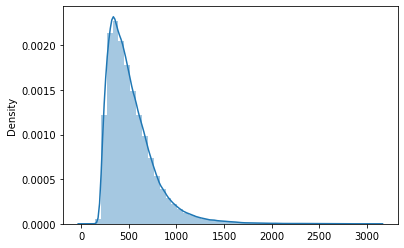

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [26]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_top_46_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[sample_x.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

65.26459795787137

In [29]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [30]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [31]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [32]:
shap_summary_df.index = x_train.columns

In [33]:
shap_summary_df.to_csv(basedir + 'shap_top_46.csv')

In [34]:
shap_summary_df.head(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,92.672444,93.414445,90.729161,92.157627,90.401479,91.875031
공시지가(만원),73.609808,74.851469,77.544954,76.748606,74.751322,75.501232
year_linear,63.356944,64.540468,65.931529,66.177450,64.132569,64.827792
건축년도,49.787690,48.301946,51.157407,49.175005,47.597789,49.203968
전용면적,41.056895,40.254464,41.775569,40.587287,38.570764,40.448996
ynorm,30.941145,30.879359,33.024696,31.911765,29.596766,31.270746
xy,21.277371,21.582534,21.386985,21.636490,22.595563,21.695789
x_2nd,18.741818,18.948716,19.337666,18.192377,19.142350,18.872585
주건축물수,11.876253,14.045022,13.256153,13.657870,12.897278,13.146515
층mean,9.727066,10.365645,10.973181,10.651070,11.576581,10.658709


In [35]:
shap_summary_df.tail(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
지형형상,1.445776,1.373069,1.392860,1.432095,1.427079,1.414176
y_sin,1.257827,1.518145,1.299712,1.120752,1.119666,1.263220
y_cos,1.236261,1.433625,1.290536,1.214744,1.085086,1.252050
x_sin,1.361228,1.263586,1.128640,1.264247,1.172334,1.238007
x_cos,1.258280,1.292865,1.158621,1.200278,1.241995,1.230408
상대정화구역,1.228713,1.092937,1.091156,1.130888,1.083927,1.125524
정비구역,1.172214,1.120243,1.066036,1.014767,1.111328,1.096917
제3종일반주거지역,1.172048,0.975026,1.165013,1.019186,0.884441,1.043143
제1종지구단위계획구역,1.070260,0.973201,1.166627,0.938340,0.900292,1.009744
중점경관관리구역,0.924918,1.043179,0.922846,1.066584,0.807689,0.953043


In [ ]:
#